## Simple Linear Regression

## Importing Libraries

In [1]:
import sys
import os

current_dir = os.getcwd() 
code_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

if code_dir not in sys.path:
    sys.path.append(code_dir)

from src.models.linear_models import LinearRegression
from src.loss_functions.regression_losses import MeanSquaredError, MeanAbsoluteError
from src.optimisers.gradient_based import BatchGradientDescent, StochasticGradientDescent, MiniBatchGradientDescent
from src.optimisers.cellular_automata import CellularAutomataOptimiser

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Loading the dataset

In [2]:
df = pd.read_csv("../datasets/simple_linear_regression_data.csv")
X = df.drop("target", axis=1)
y = df["target"]

In [3]:
TEST_SIZE = 0.2
SEED = 42

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

n_features = 1

In [5]:
RUNS = 10
final_aggregated_results = []
PLOTTING_CURVES_MSE = {}
PLOTTING_CURVES_MAE = {}
MAX_ITERS = 1000
ALPHA = 0.01
L=5
MU=0.01
OMEGA=0.8

loss_functions = {
    'Mean Squared Error': MeanSquaredError(),
    'Mean Absolute Error': MeanAbsoluteError()
}
optimisers = {
    'Batch Gradient Descent': BatchGradientDescent(ALPHA),
    'Stochastic Gradient Descent': StochasticGradientDescent(ALPHA),
    'Mini Batch Gradient Descent': MiniBatchGradientDescent(ALPHA),
    'Cellular Automata Optimiser': CellularAutomataOptimiser(L=L, mu=MU, omega=OMEGA)
}

In [6]:
print('==================== CONFIGURATIONS ====================')
print(f'MAX_ITERS={MAX_ITERS}, TEST_SIZE={TEST_SIZE}, ALPHA={ALPHA}, RUNS={RUNS}')
print(f'L={L}, μ={MU}, ω={OMEGA}')
print('='*56)

# use one optimiser at a time
for optimiser_name, optimiser in optimisers.items():
    # use one loss function at a time
    for loss_name, loss_func in loss_functions.items():
        print('='*75)
        print(f'Running Combination: {optimiser_name} / {loss_name}')

        # metric used for evaluation
        train_losses_for_avg = []
        r2_score_for_avg = []
        test_mse_for_avg = []
        test_mae_for_avg = [] 
        run_times_for_avg = []
        loss_per_iterations = []

        # test every optimiser for 10 runs
        for i in range(RUNS):
            model = LinearRegression(n_features=n_features)
            
            # calculating the time for each run
            start_time = time.time()
            optimiser_results = optimiser.optimise(model, loss_func, X_train, y_train, max_iters=MAX_ITERS) 
            run_time = time.time() - start_time

            model.set_params(optimiser_results['parameters'])
            y_pred = model.predict(X_test)

            test_mse = mean_squared_error(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            
            train_losses_for_avg.append(optimiser_results['best_loss'])
            test_mse_for_avg.append(test_mse)
            test_mae_for_avg.append(test_mae)
            r2_score_for_avg.append(r2_score(y_test, y_pred))
            run_times_for_avg.append(run_time)
            loss_per_iterations.append(optimiser_results['loss_history']) # this will store all the losses per iteration from 1 to 1000

        train_losses_array = np.array(train_losses_for_avg)
        test_mse_array = np.array(test_mse_for_avg)
        test_mae_array = np.array(test_mae_for_avg)
        r2_score_array = np.array(r2_score_for_avg)
        run_times_array = np.array(run_times_for_avg)
        loss_per_iterations_array = np.array(loss_per_iterations)

        avg_train_loss = np.mean(train_losses_array)
        std_dev_train_loss = np.std(train_losses_array)
        avg_test_mse = np.mean(test_mse_array)
        std_dev_test_mse = np.std(test_mse_array)
        avg_test_mae = np.mean(test_mae_array)
        std_dev_test_mae = np.std(test_mae_array)
        avg_r2_score = np.mean(r2_score_array)
        std_dev_r2_score = np.std(r2_score_array)
        avg_time = np.mean(run_times_array)
        std_dev_time = np.std(run_times_array)
        avg_loss_per_iter = np.mean(loss_per_iterations_array, axis=0)

        if loss_name == 'Mean Squared Error':
            PLOTTING_CURVES_MSE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MSE curve for {optimiser_name}.")
        elif loss_name == 'Mean Absolute Error':
            PLOTTING_CURVES_MAE[optimiser_name] = avg_loss_per_iter
            print(f"-> Stored average MAE curve for {optimiser_name}.")

        final_aggregated_results.append({
        'Optimiser': optimiser_name,
        'Loss_Function': loss_name,
        'Avg_Train_Loss': avg_train_loss,
        'Std_Dev_Train_Loss': std_dev_train_loss,
        'Avg_Test_MSE': avg_test_mse,
        'Std_Dev_Test_MSE': std_dev_test_mse,
        'Avg_Test_MAE': avg_test_mae,
        'Std_Dev_Test_MAE': std_dev_test_mae,
        'Avg_R2_Score': avg_r2_score,
        'Std_Dev_R2_Score': std_dev_r2_score,
        'Avg_Time_s': avg_time,
        'Std_Dev_Time_s': std_dev_time
        })

==================== CONFIGURATIONS ====================
MAX_ITERS=1000, TEST_SIZE=0.2, ALPHA=0.01, RUNS=10
L=5, μ=0.01, ω=0.8
Running Combination: Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Batch Gradient Descent.
Running Combination: Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Batch Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Stochastic Gradient Descent.
Running Combination: Stochastic Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Stochastic Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Squared Error
-> Stored average MSE curve for Mini Batch Gradient Descent.
Running Combination: Mini Batch Gradient Descent / Mean Absolute Error
-> Stored average MAE curve for Mini Batch Gradient Descent.
Running Combination: Cellular Automata Optimiser / Mean Squared Error
-> Stored average MSE curve for Ce

In [7]:
results_df = pd.DataFrame(final_aggregated_results)

output_folder = "tables"
file_name = "SLR_results.csv"
output_path = os.path.join(output_folder, file_name)

results_df.to_csv(output_path, index=False)
print(f"Successfully saved results to: {output_path}")

Successfully saved results to: tables\SLR_results.csv


In [8]:
results_df

,Optimiser,Loss_Function,Avg_Train_Loss,Std_Dev_Train_Loss,Avg_Test_MSE,Std_Dev_Test_MSE,Avg_Test_MAE,Std_Dev_Test_MAE,Avg_R2_Score,Std_Dev_R2_Score,Avg_Time_s,Std_Dev_Time_s
0,Batch Gradient Descent,Mean Squared Error,72.922528,1.098688e-08,104.202004,6.624851e-04,8.416649,3.198221e-05,0.937415,3.978948e-07,0.014969,0.002055
1,Batch Gradient Descent,Mean Absolute Error,661.867377,2.937888e+02,691877.081738,4.740916e+05,669.984490,2.866835e+02,-414.547895,2.847439e+02,0.016365,0.001698
2,Stochastic Gradient Descent,Mean Squared Error,74.682501,2.372933e-01,103.232888,3.658567e+00,8.340715,2.135679e-01,0.937997,2.197370e-03,1.627068,0.143469
3,Stochastic Gradient Descent,Mean Absolute Error,102.689124,1.053440e+02,35589.252481,4.684031e+04,112.523341,1.157085e+02,-20.375240,2.813273e+01,1.363668,0.343669
4,Mini Batch Gradient Descent,Mean Squared Error,73.785476,3.069670e+00,103.708804,5.521728e-01,8.388099,3.016793e-02,0.937712,3.316402e-04,0.051969,0.004543
5,Mini Batch Gradient Descent,Mean Absolute Error,622.207315,2.165877e+02,542791.249536,3.038374e+05,626.089753,2.043948e+02,-325.005540,1.824876e+02,0.055108,0.003094
6,Cellular Automata Optimiser,Mean Squared Error,72.922528,1.740467e-14,104.202227,7.864541e-07,8.416660,4.112057e-08,0.937415,4.723517e-10,3.692773,0.060270
7,Cellular Automata Optimiser,Mean Absolute Error,6.834425,2.324657e-05,107.726569,1.255113e-02,8.611092,6.716725e-04,0.935298,7.538326e-06,2.430277,0.438244


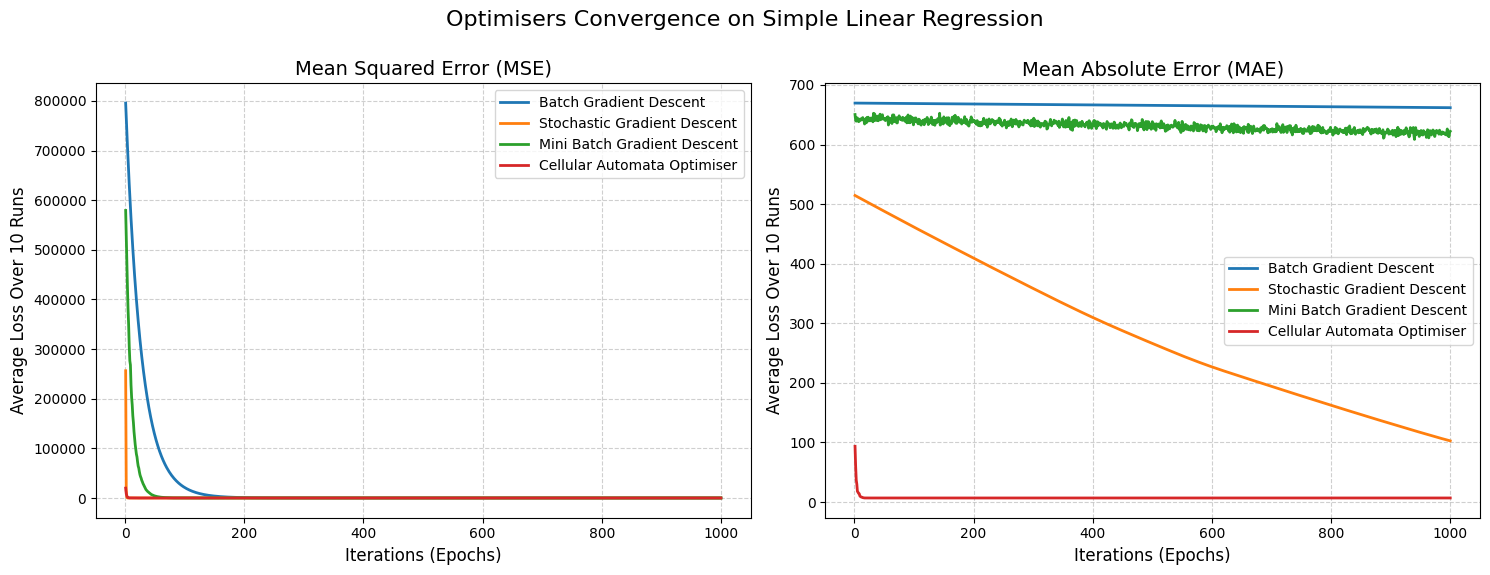

In [9]:
iterations = np.arange(1, MAX_ITERS + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# for Mean Squared Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MSE.items():
    ax[0].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[0].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()

# for Mean Absolute Error
for optimiser_name, avg_curve in PLOTTING_CURVES_MAE.items():
    ax[1].plot(iterations, avg_curve, label=optimiser_name, linewidth=2)

ax[1].set_title('Mean Absolute Error (MAE)', fontsize=14)
ax[1].set_xlabel('Iterations (Epochs)', fontsize=12)
ax[1].set_ylabel('Average Loss Over 10 Runs', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend()

fig.suptitle('Optimisers Convergence on Simple Linear Regression', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Simple Linear Regression Loss Plot.png')